In [236]:
import pandas as pd
import numpy as np
import shapely

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [237]:
#crime = pd.read_csv('./train.csv')    # read in crime
crime = pd.read_csv('./SFPD_Incidents_-_from_1_January_2003.csv')

In [238]:
crime_sub = crime.sample(500000)   #subset sample
crime_sub.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
1007047,60143515,LARCENY/THEFT,GRAND THEFT PICKPOCKET,Tuesday,02/07/2006,00:30,NORTHERN,NOT PROSECUTED,3200 Block of SCOTT ST,-122.441148,37.799702,"(37.7997018632448, -122.441147713309)",6014351506113
1342725,41247974,SUSPICIOUS OCC,SUSPICIOUS OCCURRENCE,Monday,11/01/2004,07:00,TENDERLOIN,NONE,200 Block of MCALLISTER ST,-122.415716,37.780613,"(37.7806128321539, -122.415715948543)",4124797464070
18550,150320104,OTHER OFFENSES,EVADING A POLICE OFFICER RECKLESSLY,Sunday,04/12/2015,17:49,CENTRAL,NONE,2800 Block of LEAVENWORTH ST,-122.418930,37.807350,"(37.8073502516323, -122.418930302924)",15032010427175
77179,140211563,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Sunday,03/09/2014,01:30,SOUTHERN,NONE,1200 Block of FOLSOM ST,-122.410900,37.774408,"(37.7744077759133, -122.410900108267)",14021156306244
673609,40425656,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Tuesday,04/13/2004,22:00,BAYVIEW,NONE,600 Block of MISSISSIPPI ST,-122.394298,37.758851,"(37.7588506500293, -122.394297586282)",4042565606244


In [239]:
district_coordinates = pd.read_csv('./district_coordinates.csv')   # read in coordinates
del district_coordinates['Unnamed: 0']
district_coordinates = district_coordinates.dropna()

In [240]:
district_coordinates.head()

,district,lat,lon
0,bernal heights,37.7412,-122.4178
1,castro,37.7609,-122.4350
2,chinatown,37.7941,-122.4078
4,excelsior,37.7244,-122.4272
5,financial district,37.7946,-122.3999


# Function to map crime location coordinates to districts

In [241]:
# get decimals as a feature X1 X2 from the location coordinates
from decimal import Decimal
def replace_lon(location):
    
    lon = str(location).replace('(','').replace(')','').split(',')
    lon = np.float64(lon[1])
    return lon
    
def replace_lat(location):
    lat = str(location).replace('(','').replace(')','').split(',')
    lat = np.float64(lat[0])
    return lat
    
crime_sub['X1'] = crime_sub.apply(lambda row: replace_lon(row['Location']),axis = 1)
crime_sub['Y1'] = crime_sub.apply(lambda row: replace_lat(row['Location']),axis = 1)

# haversine distances to check which crime occured in what district
%timeit
from haversine import haversine
def check_distance(location):
    #print location
    haversine_list = []
    for d,lat,lon in zip(district_coordinates.district,district_coordinates.lat, district_coordinates.lon):

        haversine_list.append((haversine(location, (lon,lat)),d))
    
    match = sorted(haversine_list)[0][1]
    return match
    
crime_sub['match_district'] = crime_sub.apply(lambda row: check_distance((row['X1'],row['Y1'])), axis = 1 )

In [242]:
crime_sub.head(2)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId,X1,Y1,match_district
1007047,60143515,LARCENY/THEFT,GRAND THEFT PICKPOCKET,Tuesday,02/07/2006,00:30,NORTHERN,NOT PROSECUTED,3200 Block of SCOTT ST,-122.441148,37.799702,"(37.7997018632448, -122.441147713309)",6014351506113,-122.441148,37.799702,marina
1342725,41247974,SUSPICIOUS OCC,SUSPICIOUS OCCURRENCE,Monday,11/01/2004,07:00,TENDERLOIN,NONE,200 Block of MCALLISTER ST,-122.415716,37.780613,"(37.7806128321539, -122.415715948543)",4124797464070,-122.415716,37.780613,tenderloin


## Create crime categories for classification of crime types for EDA

In [243]:
# create crime Categories
crime_sub.Category.value_counts()

theft = ['LARCENY/THEFT','VEHICLE THEFT','BURGLARY','ROBBERY','STOLEN PROPERTY','RECOVERED VEHICLE']
drunk = ['DRUG/NARCOTIC','DRUNKENNESS','LIQOUR LAWS','DRIVING UNDER THE INFLUENCE','LIQUOR LAWS']
organized = ['BRIBERY','EXTORTION','PROSTITUTION']
violent = ['ASSAULT','SEX OFFENSES, FORCIBLE','KIDNAPPING']
narcotic = ['DRUG/NARCOTIC']
city = ['VANDALISM','LOITERING']

crime_sub['is_theft'] = crime_sub.Category.apply(lambda x: 1 if x in theft else 0)
crime_sub['is_drunk'] = crime_sub.Category.apply(lambda x: 1 if x in drunk else 0)
crime_sub['is_organized'] = crime_sub.Category.apply(lambda x: 1 if x in organized else 0)
crime_sub['is_violent'] = crime_sub.Category.apply(lambda x: 1 if x in violent else 0)
crime_sub['is_narcotic'] = crime_sub.Category.apply(lambda x: 1 if x in narcotic else 0)
crime_sub['is_city'] = crime_sub.Category.apply(lambda x: 1 if x in city else 0)

In [244]:
crime_sub.head(2)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,...,PdId,X1,Y1,match_district,is_theft,is_drunk,is_organized,is_violent,is_narcotic,is_city
1007047,60143515,LARCENY/THEFT,GRAND THEFT PICKPOCKET,Tuesday,02/07/2006,00:30,NORTHERN,NOT PROSECUTED,3200 Block of SCOTT ST,-122.441148,...,6014351506113,-122.441148,37.799702,marina,1,0,0,0,0,0
1342725,41247974,SUSPICIOUS OCC,SUSPICIOUS OCCURRENCE,Monday,11/01/2004,07:00,TENDERLOIN,NONE,200 Block of MCALLISTER ST,-122.415716,...,4124797464070,-122.415716,37.780613,tenderloin,0,0,0,0,0,0


## Convert indexes and dates to datetime

In [245]:
from datetime import datetime as dt
print crime_sub.index.dtype
crime_sub['Date'] = pd.to_datetime(crime_sub['Date'])
crime_sub.set_index('Date',inplace= True)
print crime_sub.index.dtype
crime_sub.index

int64
datetime64[ns]


DatetimeIndex(['2006-02-07', '2004-11-01', '2015-04-12', '2014-03-09',
               '2004-04-13', '2015-09-07', '2003-03-01', '2005-02-18',
               '2007-01-24', '2013-06-11',
               ...
               '2016-02-03', '2003-08-10', '2007-04-20', '2015-02-08',
               '2004-03-03', '2009-01-01', '2008-06-23', '2015-05-18',
               '2008-10-29', '2016-01-14'],
              dtype='datetime64[ns]', name=u'Date', length=500000, freq=None)

In [246]:
# create a year function, 2016 is not completely represented
crime_sub['year'] = crime_sub.index.map(lambda val: val.year)
crime_sub.head(1)
crime_sub = crime_sub[crime_sub['year'] < 2016]

In [247]:
crime_sub.year.value_counts()

2015    40619
2013    39723
2014    39186
2003    39090
2004    38695
2005    37491
2008    36789
2009    36660
2012    36544
2006    36310
2007    35747
2011    34835
2010    34641
Name: year, dtype: int64

## Posts read in

In [248]:
posts = pd.read_csv('./craigslist_posts.csv')
posts.head()
posts = posts[posts.bed < 6]
posts = posts[posts.price < 50000]

# EDA

In [249]:
crime_eda = crime_sub[['Category','Resolution','match_district','is_theft','is_organized','is_violent','is_narcotic','is_city','year']]
crime_eda.head()

,Category,Resolution,match_district,is_theft,is_organized,is_violent,is_narcotic,is_city,year
Date,,,,,,,,,
2006-02-07,LARCENY/THEFT,NOT PROSECUTED,marina,1,0,0,0,0,2006
2004-11-01,SUSPICIOUS OCC,NONE,tenderloin,0,0,0,0,0,2004
2015-04-12,OTHER OFFENSES,NONE,russian hill,0,0,0,0,0,2015
2014-03-09,LARCENY/THEFT,NONE,south of market,1,0,0,0,0,2014
2004-04-13,LARCENY/THEFT,NONE,potrero hill,1,0,0,0,0,2004


In [250]:
crime_eda.groupby('year').sum().head()

,is_theft,is_organized,is_violent,is_narcotic,is_city
year,,,,,
2003,13639,560,3767,2567,1767
2004,13814,431,3645,2554,1755
2005,14567,337,3287,2227,1880
2006,12497,334,3446,2363,2074
2007,11240,528,3467,2733,2057


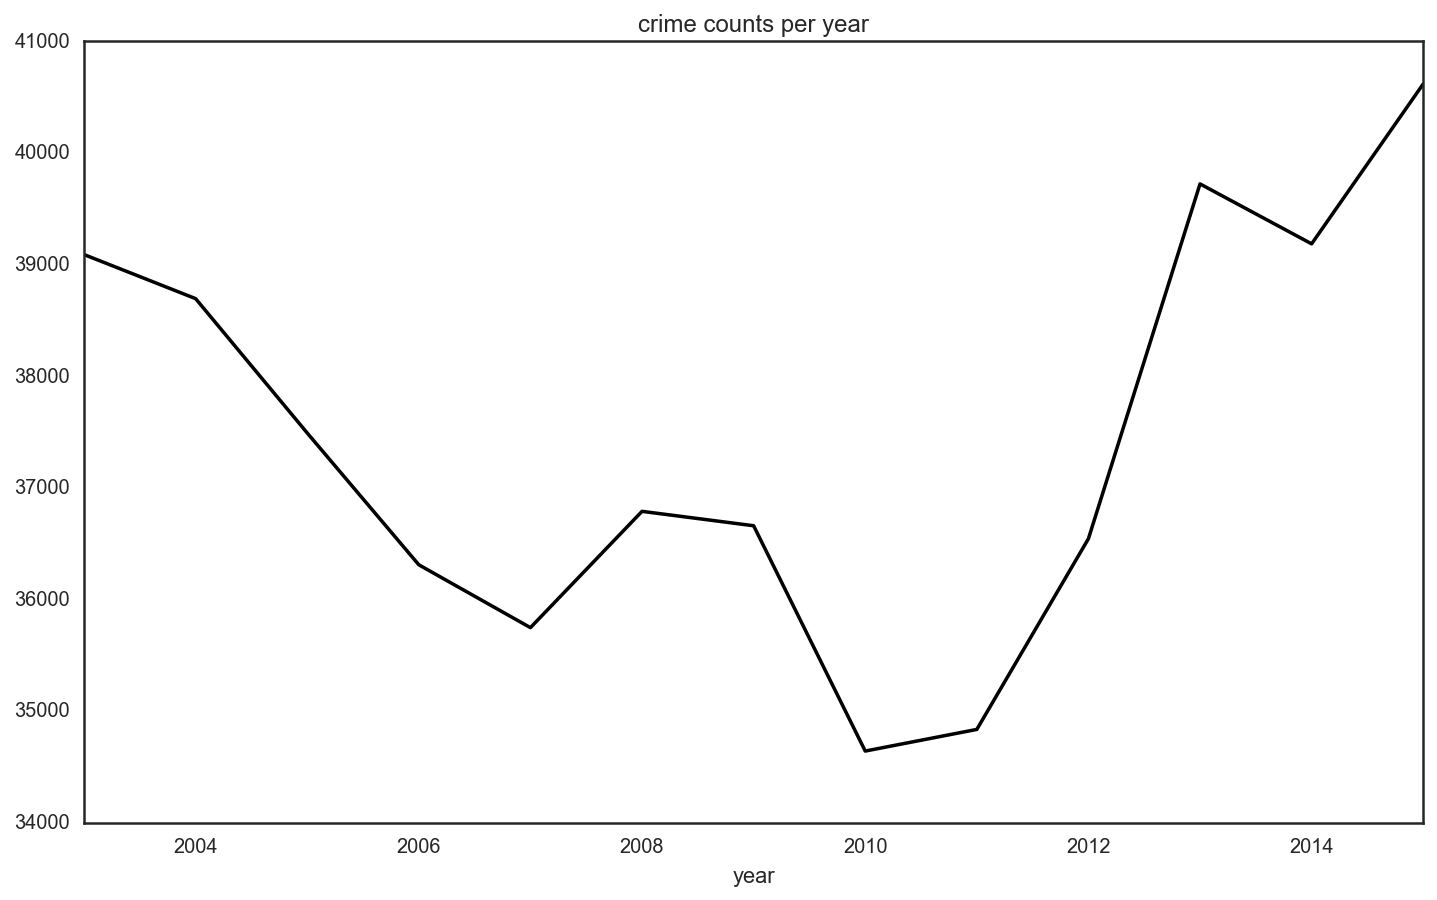

In [293]:
sns.set(rc={"figure.figsize": (12, 7)})
sns.set_style("white")
crime_eda.groupby('year').count().Category.plot(title = "crime counts per year", color = 'black')

# programs underfunded and municipal parts were closed down, population rose but number of police on the street actually dropped
# spike of crime, cite some articles that recall when schwarzenegger was governor he got rid of majorit vote rule, a lot of budgets couldn't
# be passed without 3/4 majority vote, most break ins 

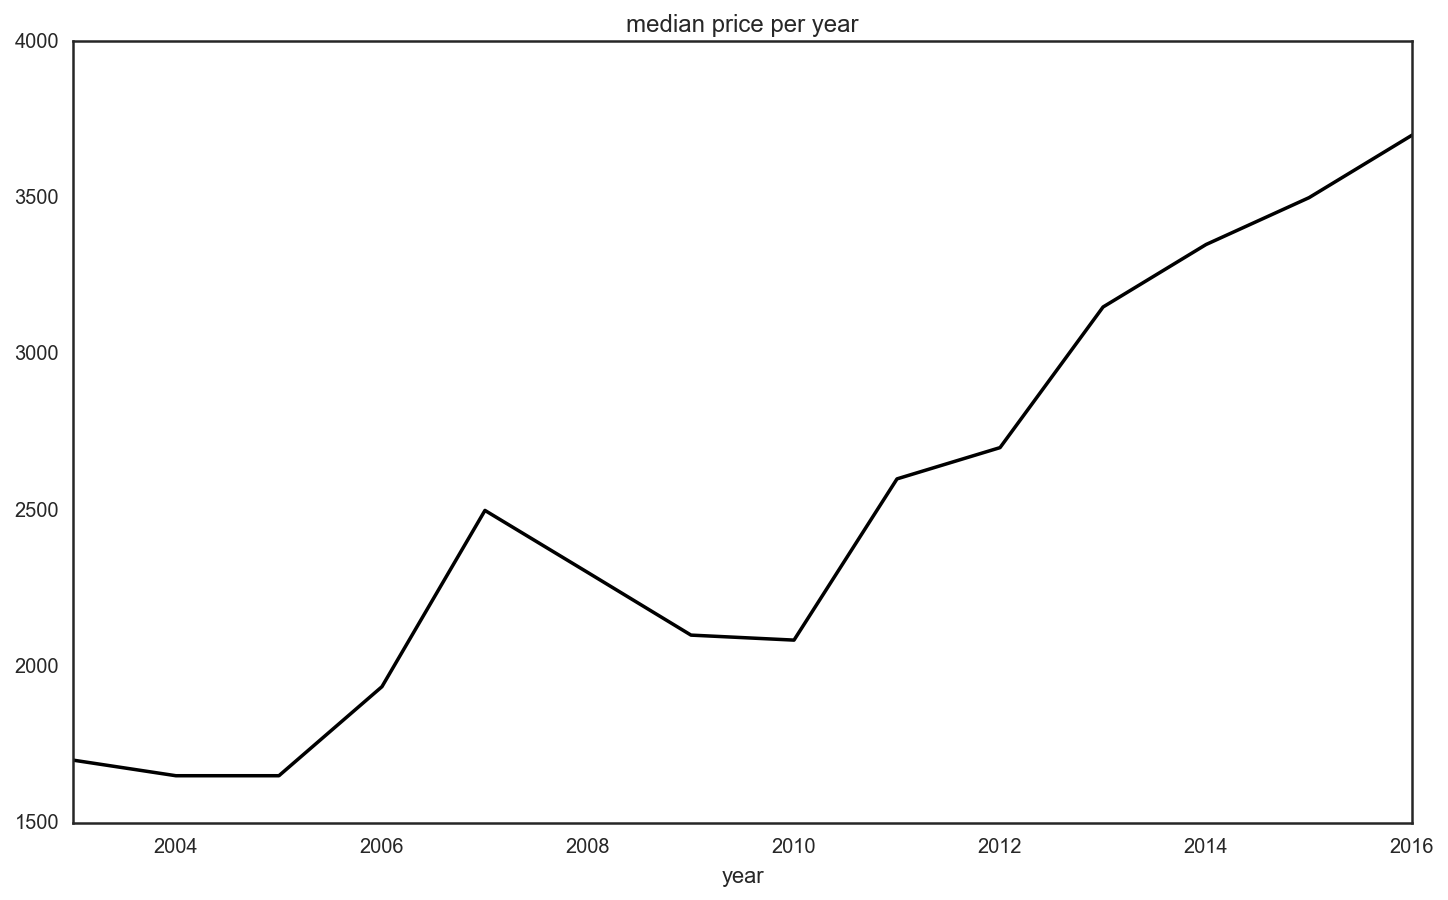

In [296]:
sns.set(rc={"figure.figsize": (12,7)})
sns.set_style("white")
#price by year of housing
posts_eda = posts[posts['price']<50000]
posts_eda.groupby('year')['price'].median().plot(title = 'median price per year', color = 'black')

#posts_eda.groupby(['district1','year']).mean().price

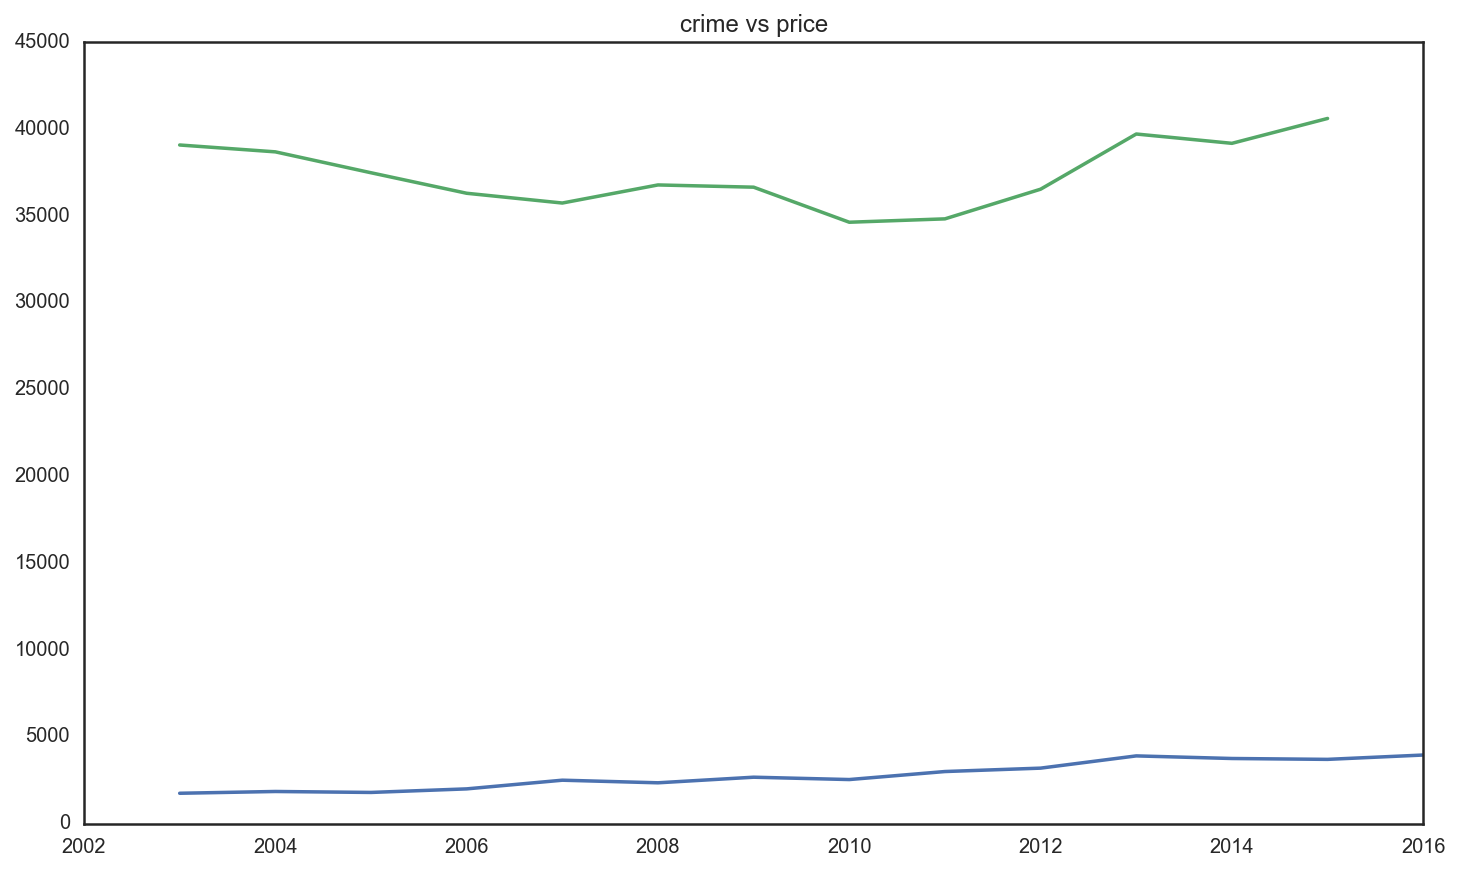

In [258]:
sns.set(rc={"figure.figsize": (12,7)})
sns.set_style('white')
plt.plot(posts_eda.groupby('year')['price'].median())
plt.plot(crime_eda.groupby('year').count().Category)
plt.title('crime vs price')
plt.show()


In [141]:
posts_eda.groupby('year')['price'].median()

year
2003    1700.0
2004    1650.0
2005    1650.0
2006    1935.0
2007    2499.0
2008    2300.0
2009    2100.0
2010    2084.0
2011    2600.0
2012    2700.0
2013    3150.0
2014    3350.0
2015    3500.0
2016    3700.0
Name: price, dtype: float64

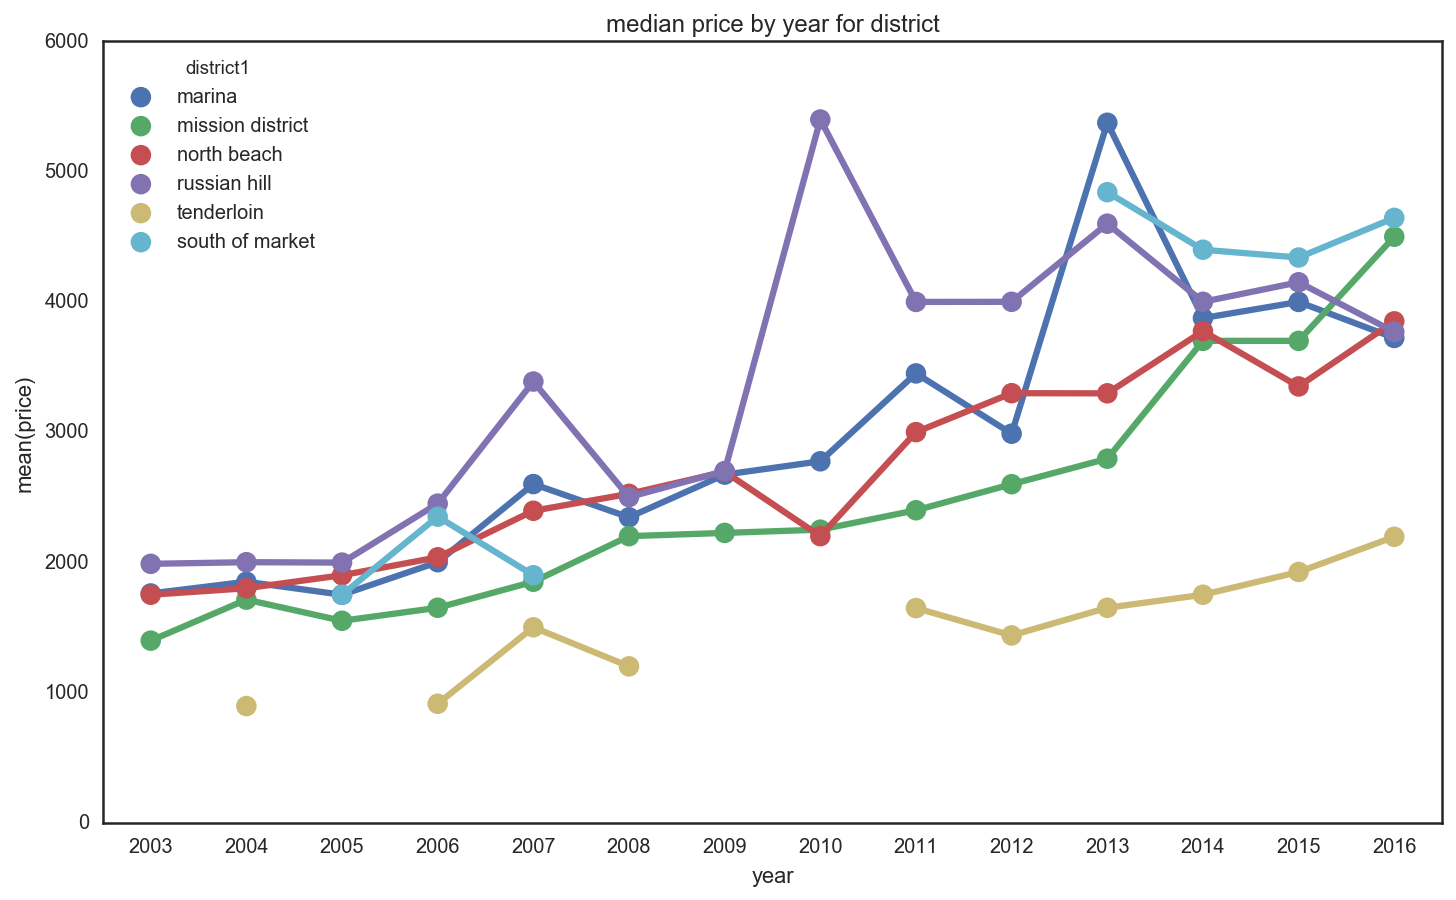

In [295]:
# average price by district
sns.set(rc={"figure.figsize": (12, 7)})
sns.set_style("white")
posts_eda = posts_eda[posts_eda.district1.isin(['mission district','south of market','marina','russian hill','north beach','tenderloin']) == True]
posts_eda1 = pd.DataFrame(posts_eda.groupby(['year','district1']).median()).reset_index()
posts_eda1.drop('bed',axis = 1,inplace = True)

g = sns.pointplot(x = 'year',y= 'price',data = posts_eda1,hue = 'district1')
g.axes.set_title('median price by year for district')

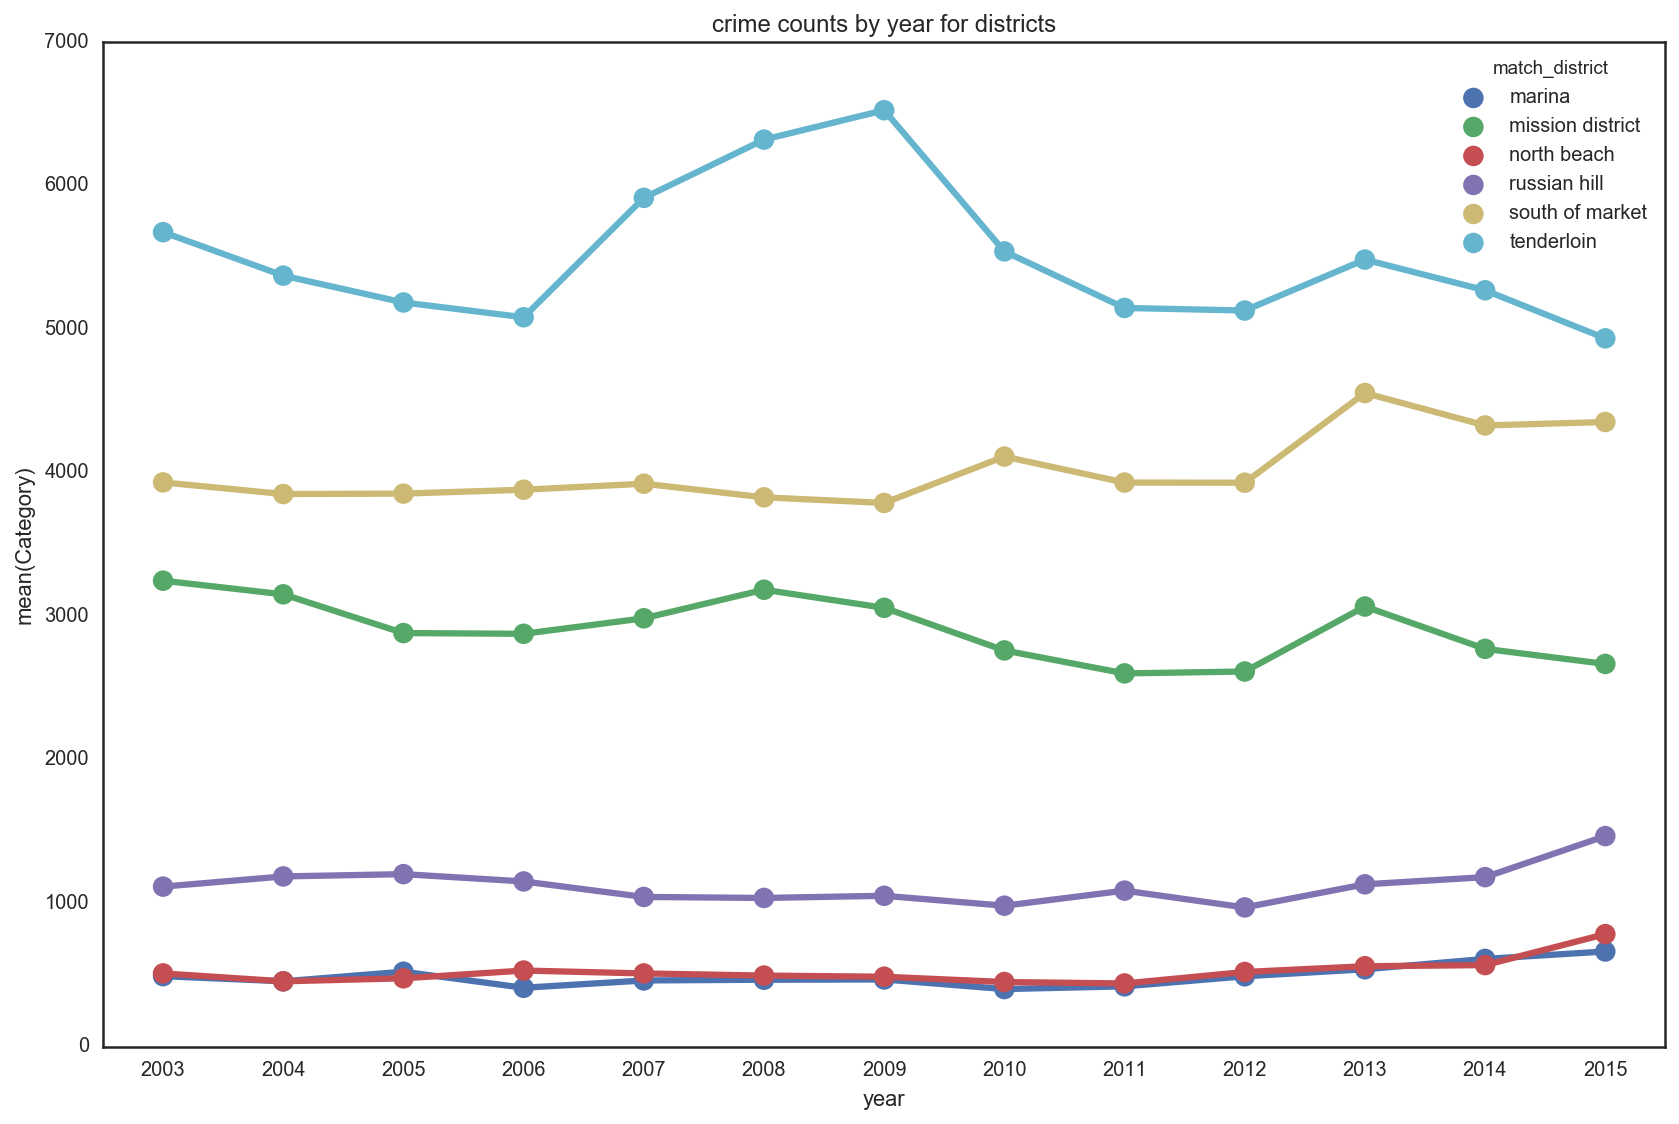

In [269]:
#total crimes per year by district
sns.set(rc={"figure.figsize": (14, 9)})

sns.set_style("white")
crime_sub_eda = crime_sub[crime_sub.match_district.isin(['mission district','south of market','marina','russian hill','north beach','tenderloin']) == True]
crime_sub_eda1 = pd.DataFrame(crime_sub_eda.groupby(['year','match_district']).count()['Category']).reset_index()
g = sns.pointplot(x = 'year',y= 'Category',data = crime_sub_eda1,hue = 'match_district')
g.axes.set_title('crime counts by year for districts')

In [270]:
crime_sub[crime_sub.is_theft == 1].groupby('year')['is_theft'].sum()

year
2003    13639
2004    13814
2005    14567
2006    12497
2007    11240
2008    11345
2009    10715
2010     9994
2011    10530
2012    12598
2013    14431
2014    14627
2015    16082
Name: is_theft, dtype: int64

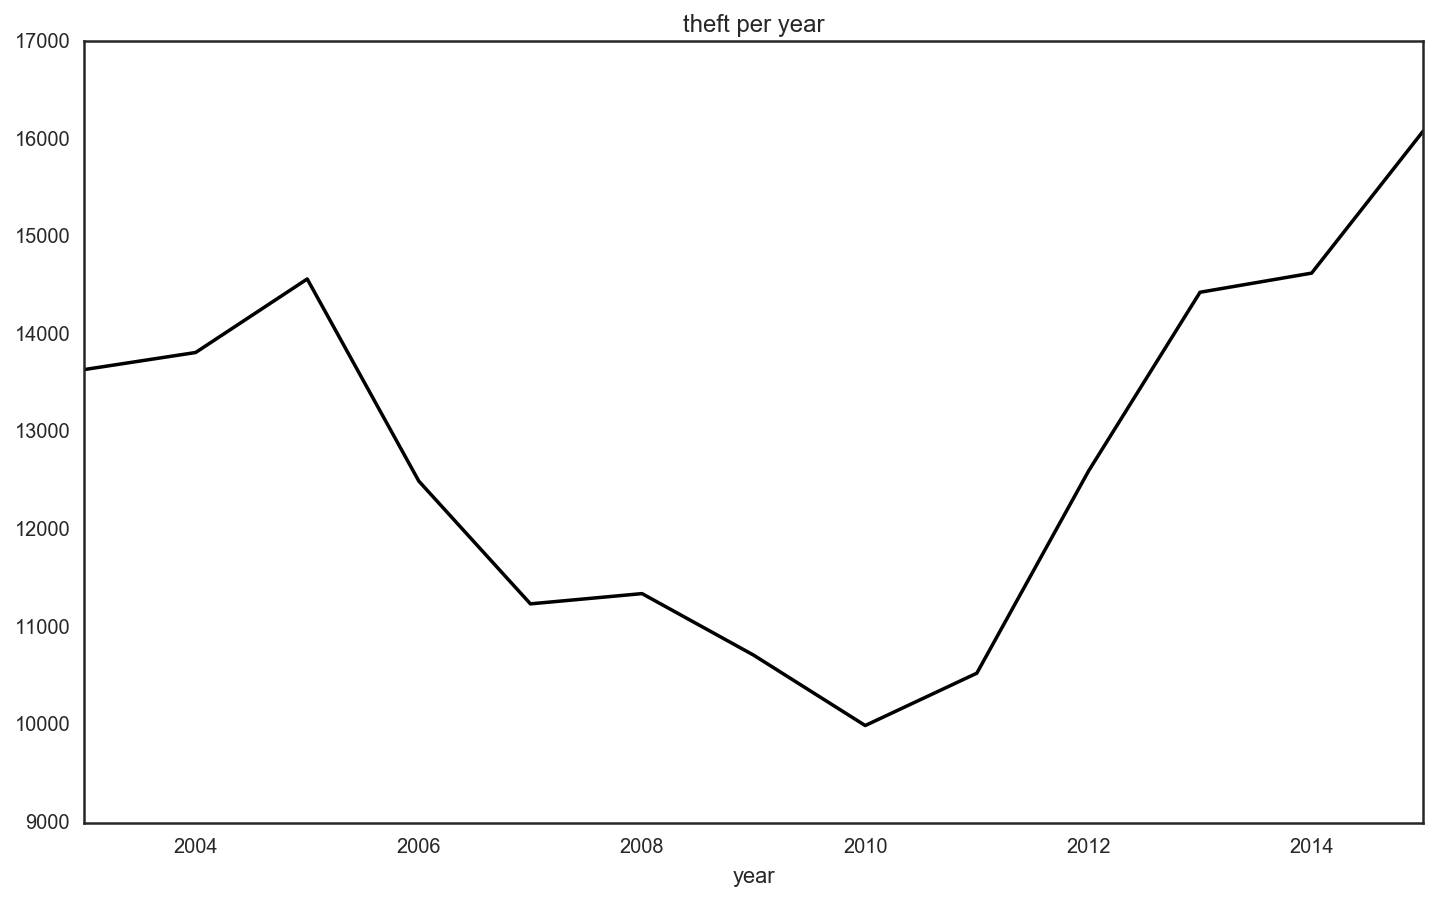

In [297]:
sns.set(rc={"figure.figsize": (12, 7)})
sns.set_style("white")
crime_sub[crime_sub.is_theft == 1].groupby('year')['is_theft'].sum()[0:13].plot(title="theft per year", color = 'black')

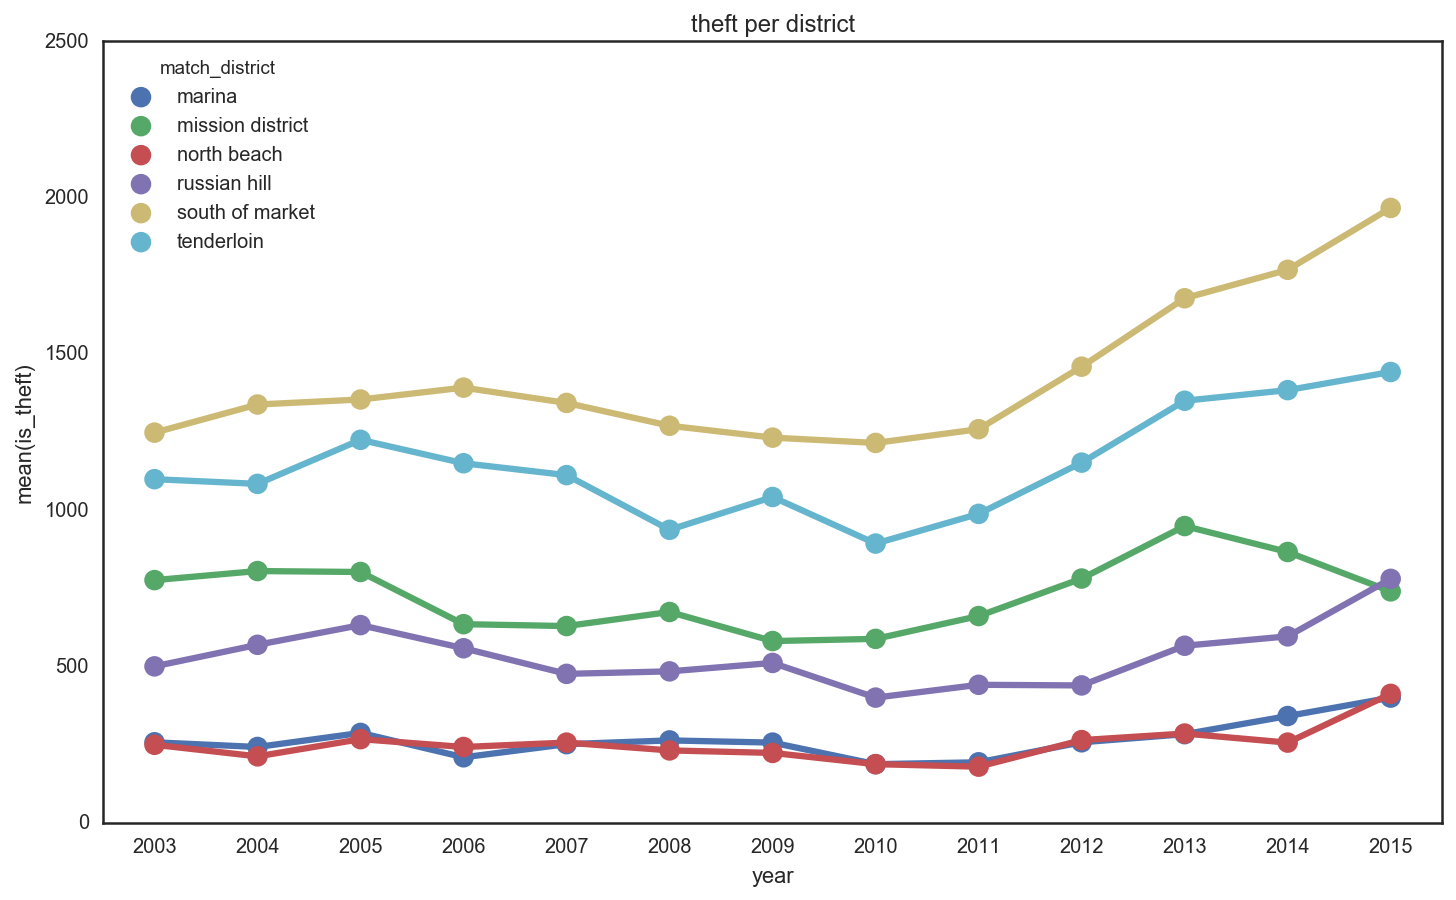

In [274]:
sns.set_style('white')

crime_sub_eda = crime_sub[crime_sub['is_theft'] == 1]
crime_sub_eda = crime_sub_eda[crime_sub_eda.match_district.isin(['mission district','south of market','marina','russian hill','north beach','tenderloin']) == True]
crime_sub_eda1 = pd.DataFrame(crime_sub_eda.groupby(['year','match_district']).count()['is_theft']).reset_index()
g = sns.pointplot(x = 'year',y= 'is_theft',data = crime_sub_eda1,hue = 'match_district')
g.axes.set_title("theft per district")

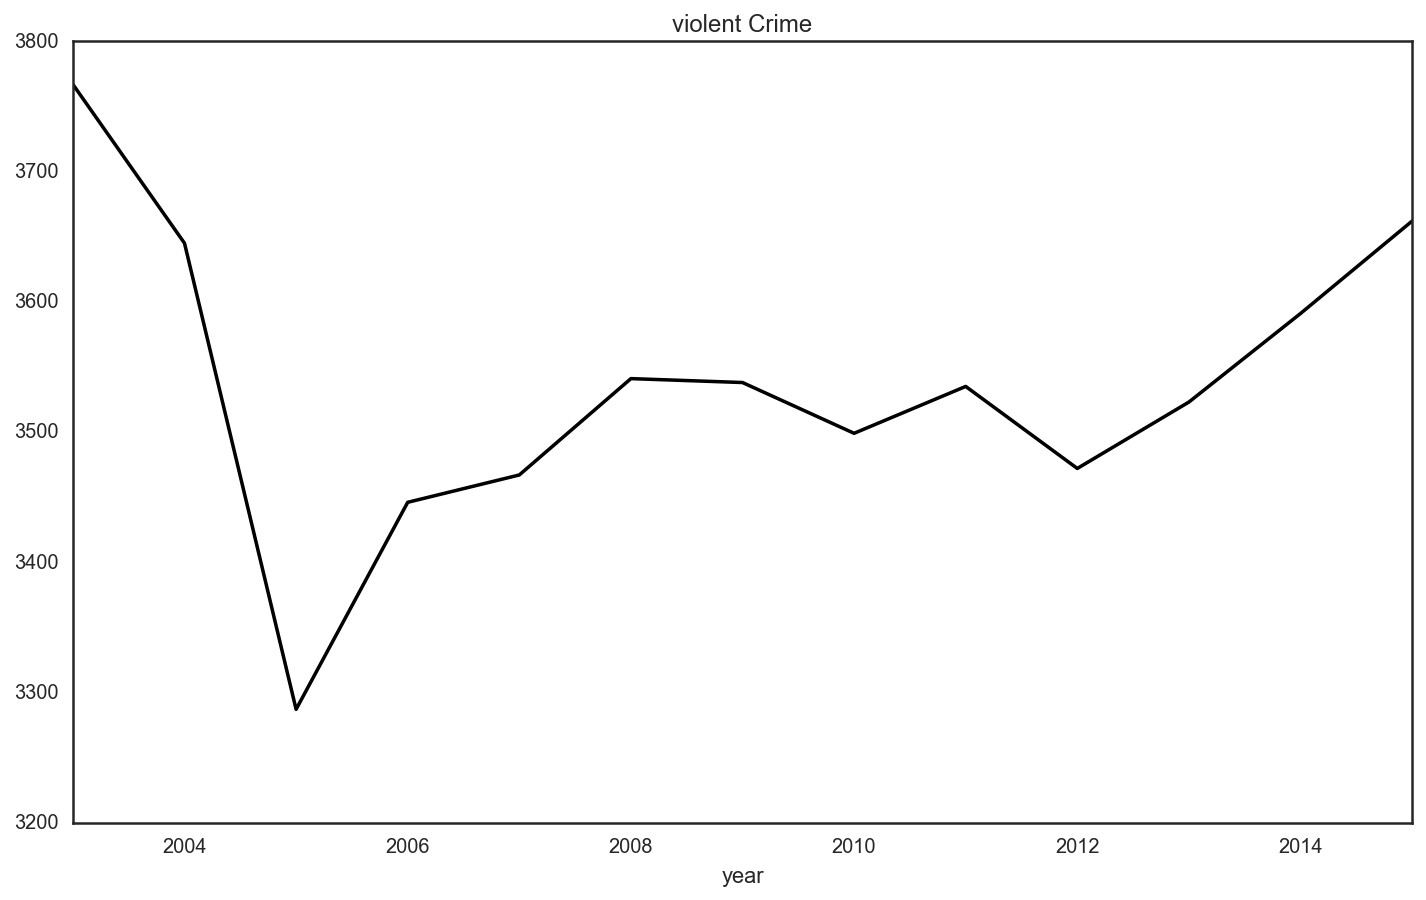

In [298]:
sns.set(rc={"figure.figsize": (12, 7)})
sns.set_style("white")
crime_sub[crime_sub.is_violent == 1].groupby('year')['is_violent'].sum()[0:13].plot(title = "violent Crime", color = 'black')


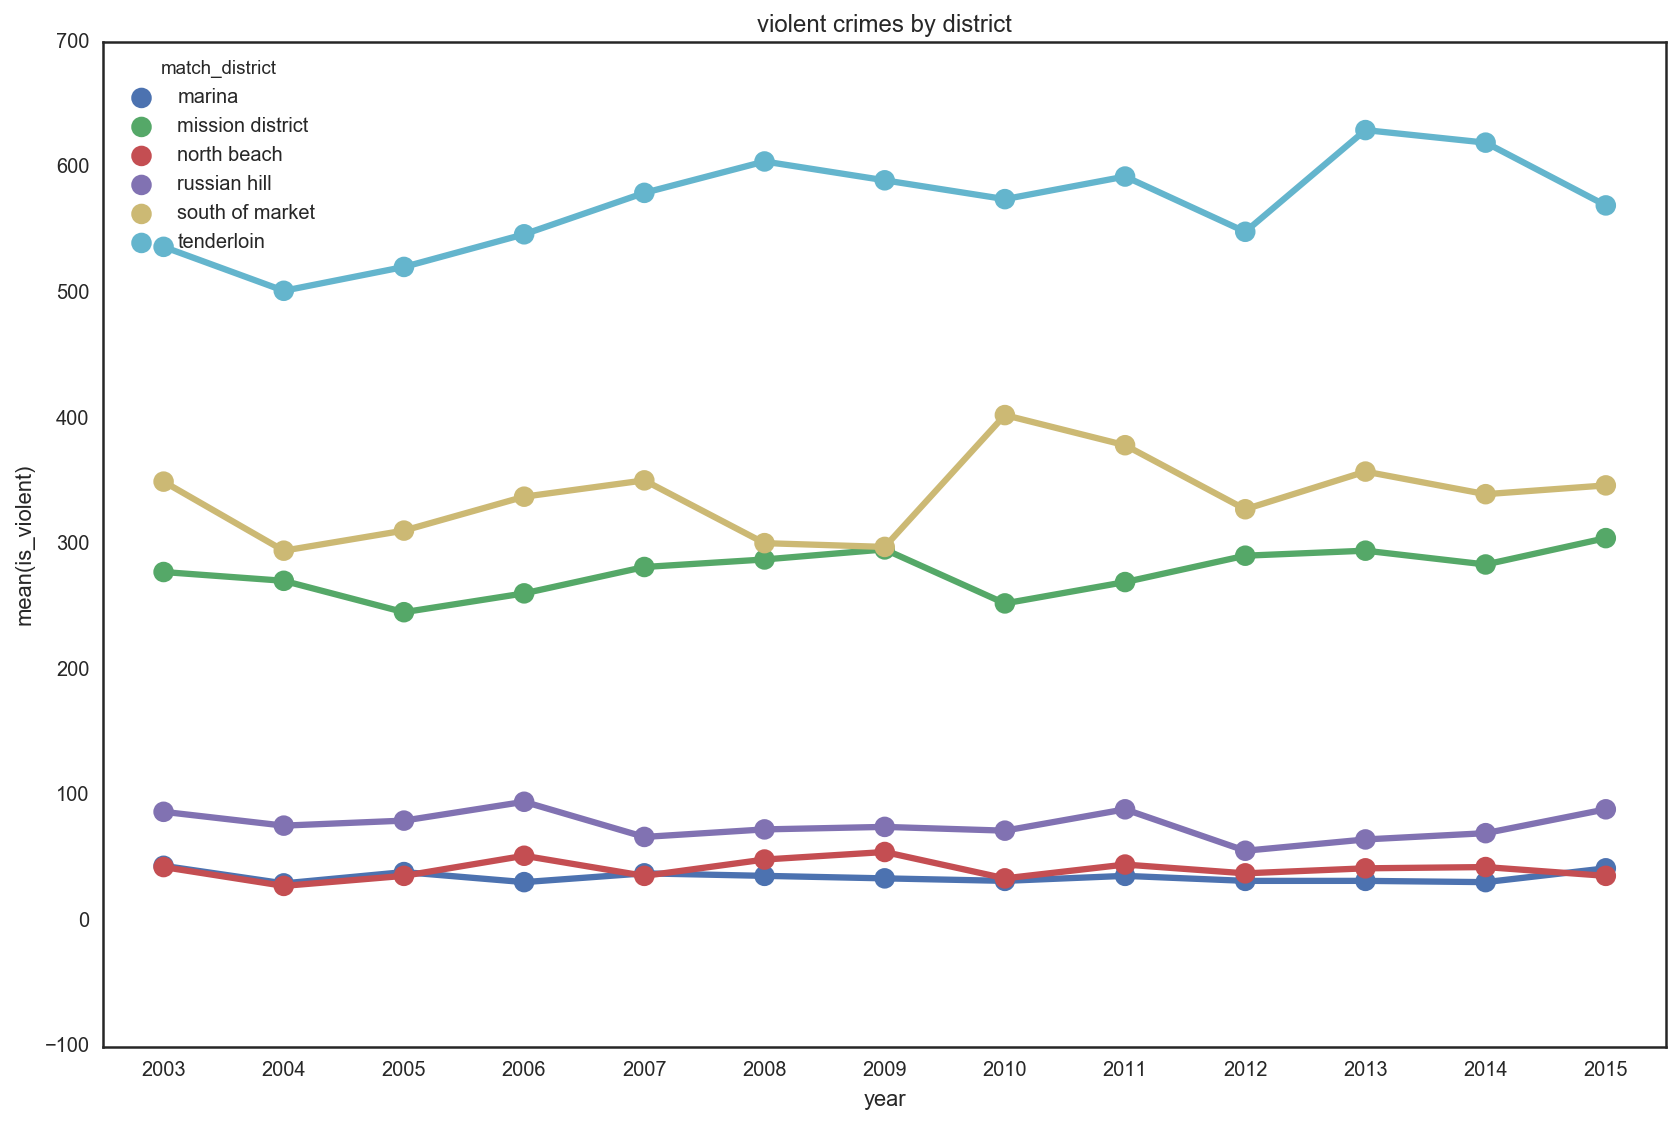

In [281]:
sns.set(rc={"figure.figsize": (14, 9)})
sns.set_style('white')

crime_sub_eda = crime_sub[crime_sub['is_violent'] == 1]
crime_sub_eda = crime_sub_eda[crime_sub_eda.match_district.isin(['mission district','south of market','marina','russian hill','north beach','tenderloin']) == True]
crime_sub_eda1 = pd.DataFrame(crime_sub_eda.groupby(['year','match_district']).count()['is_violent']).reset_index()
g = sns.pointplot(x = 'year',y= 'is_violent',data = crime_sub_eda1,hue = 'match_district')
g.axes.set_title('violent crimes by district')

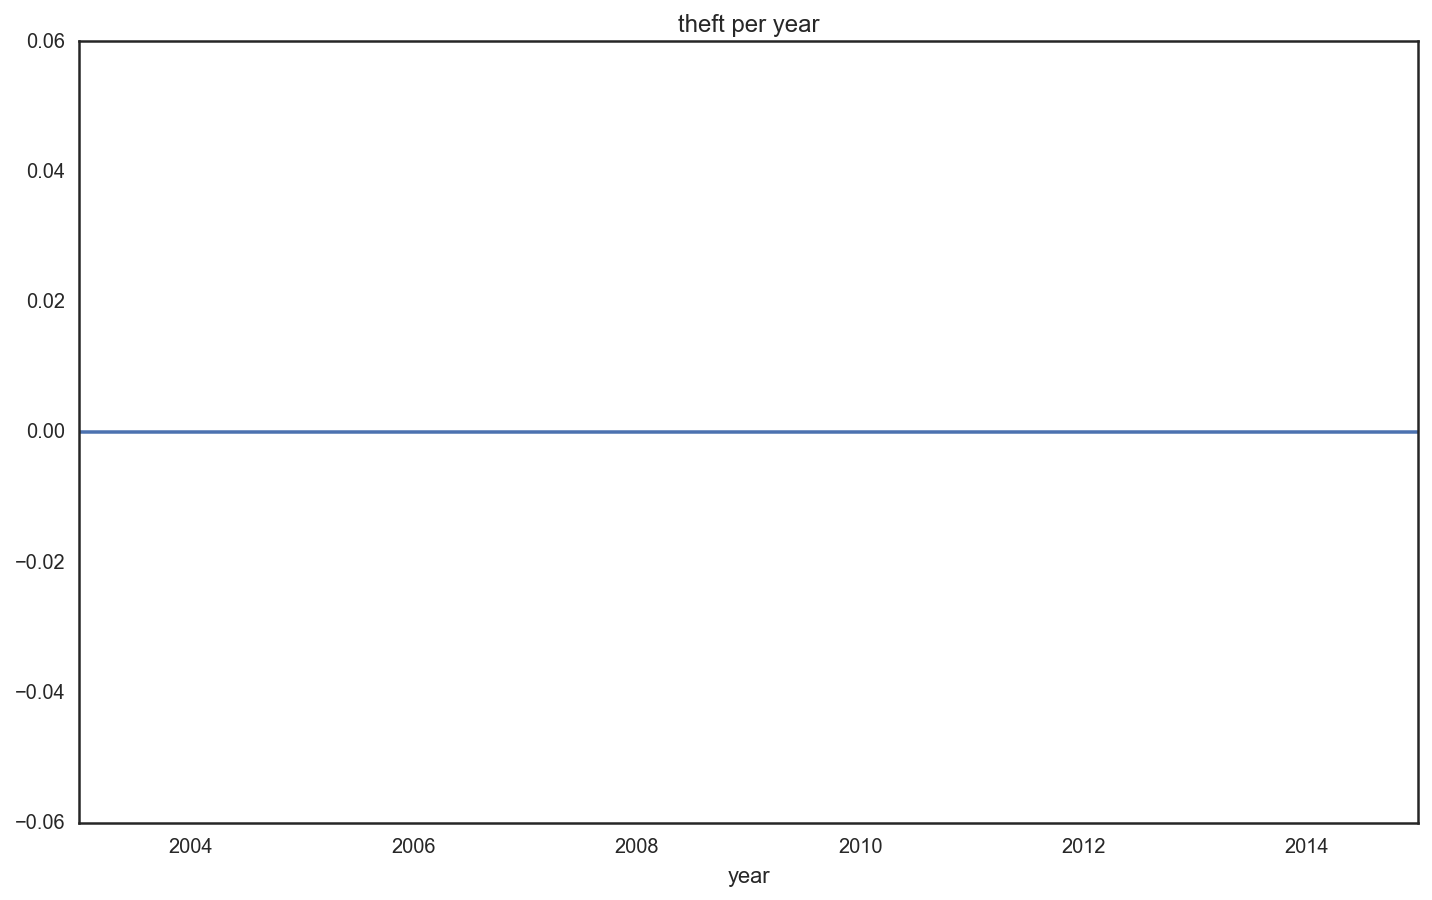

In [289]:
sns.set(rc={"figure.figsize": (12, 7)})
sns.set_style("white")
crime_sub[crime_sub.is_theft == 1].groupby('year')['is_narcotic'].sum()[0:13].plot(title="theft per year")

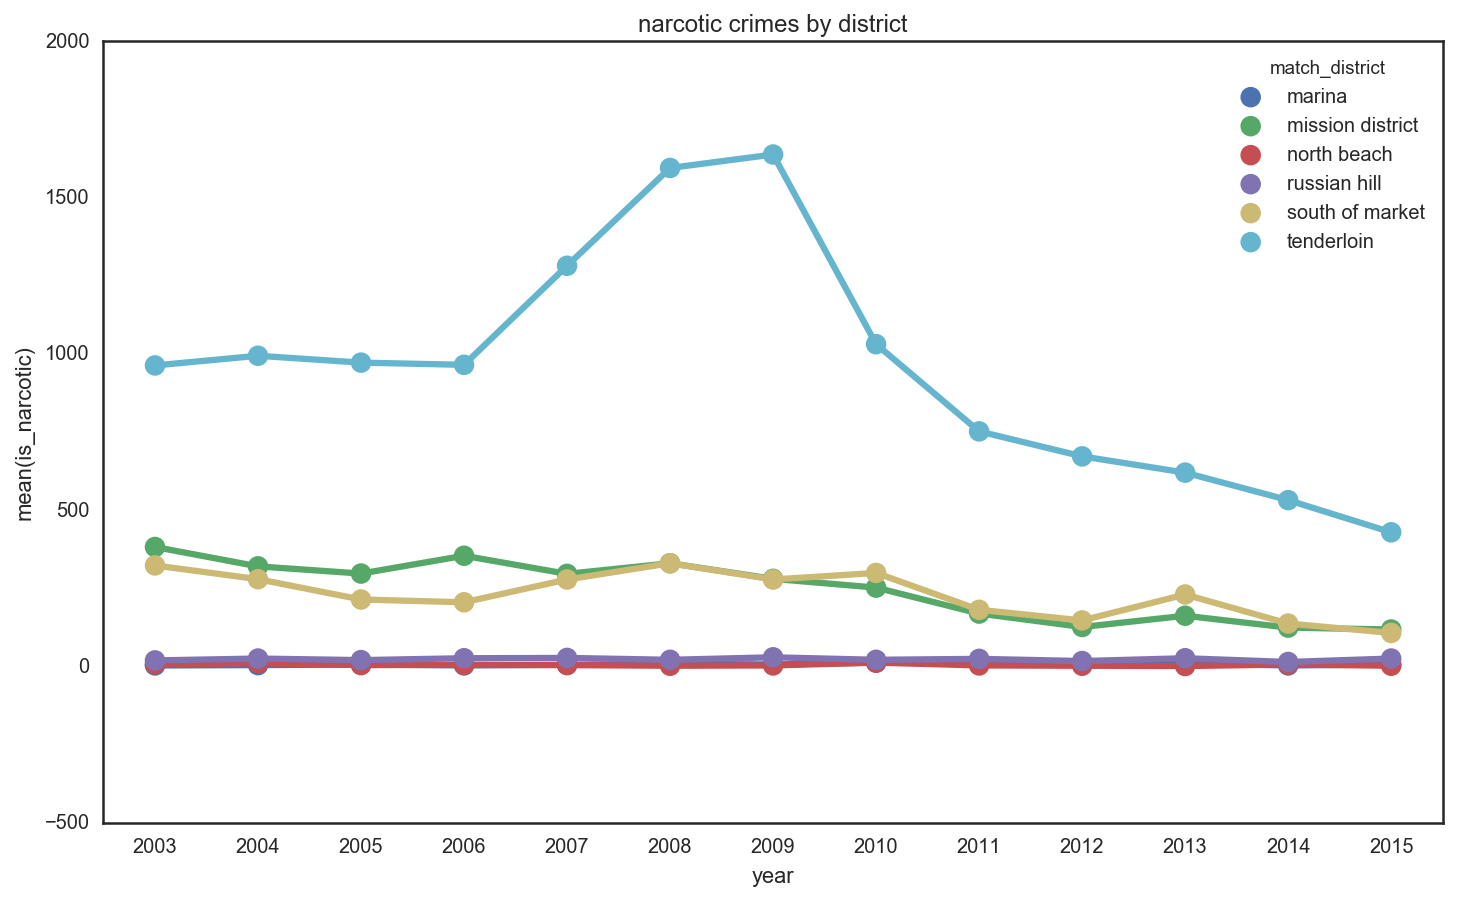

In [286]:
sns.set_style('white')
crime_sub_eda = crime_sub[crime_sub['is_narcotic'] == 1]
crime_sub_eda = crime_sub_eda[crime_sub_eda.match_district.isin(['mission district','south of market','marina','russian hill','north beach','tenderloin']) == True]
crime_sub_eda1 = pd.DataFrame(crime_sub_eda.groupby(['year','match_district']).count()['is_narcotic']).reset_index()
g = sns.pointplot(x = 'year',y= 'is_narcotic',data = crime_sub_eda1,hue = 'match_district')
g.axes.set_title('narcotic crimes by district')

LARCENY/THEFT     99048
OTHER OFFENSES    69276
NON-CRIMINAL      51618
ASSAULT           42292
VEHICLE THEFT     29436
DRUG/NARCOTIC     28749
VANDALISM         24852
WARRANTS          23187
BURGLARY          20496
SUSPICIOUS OCC    17443
Name: Category, dtype: int64


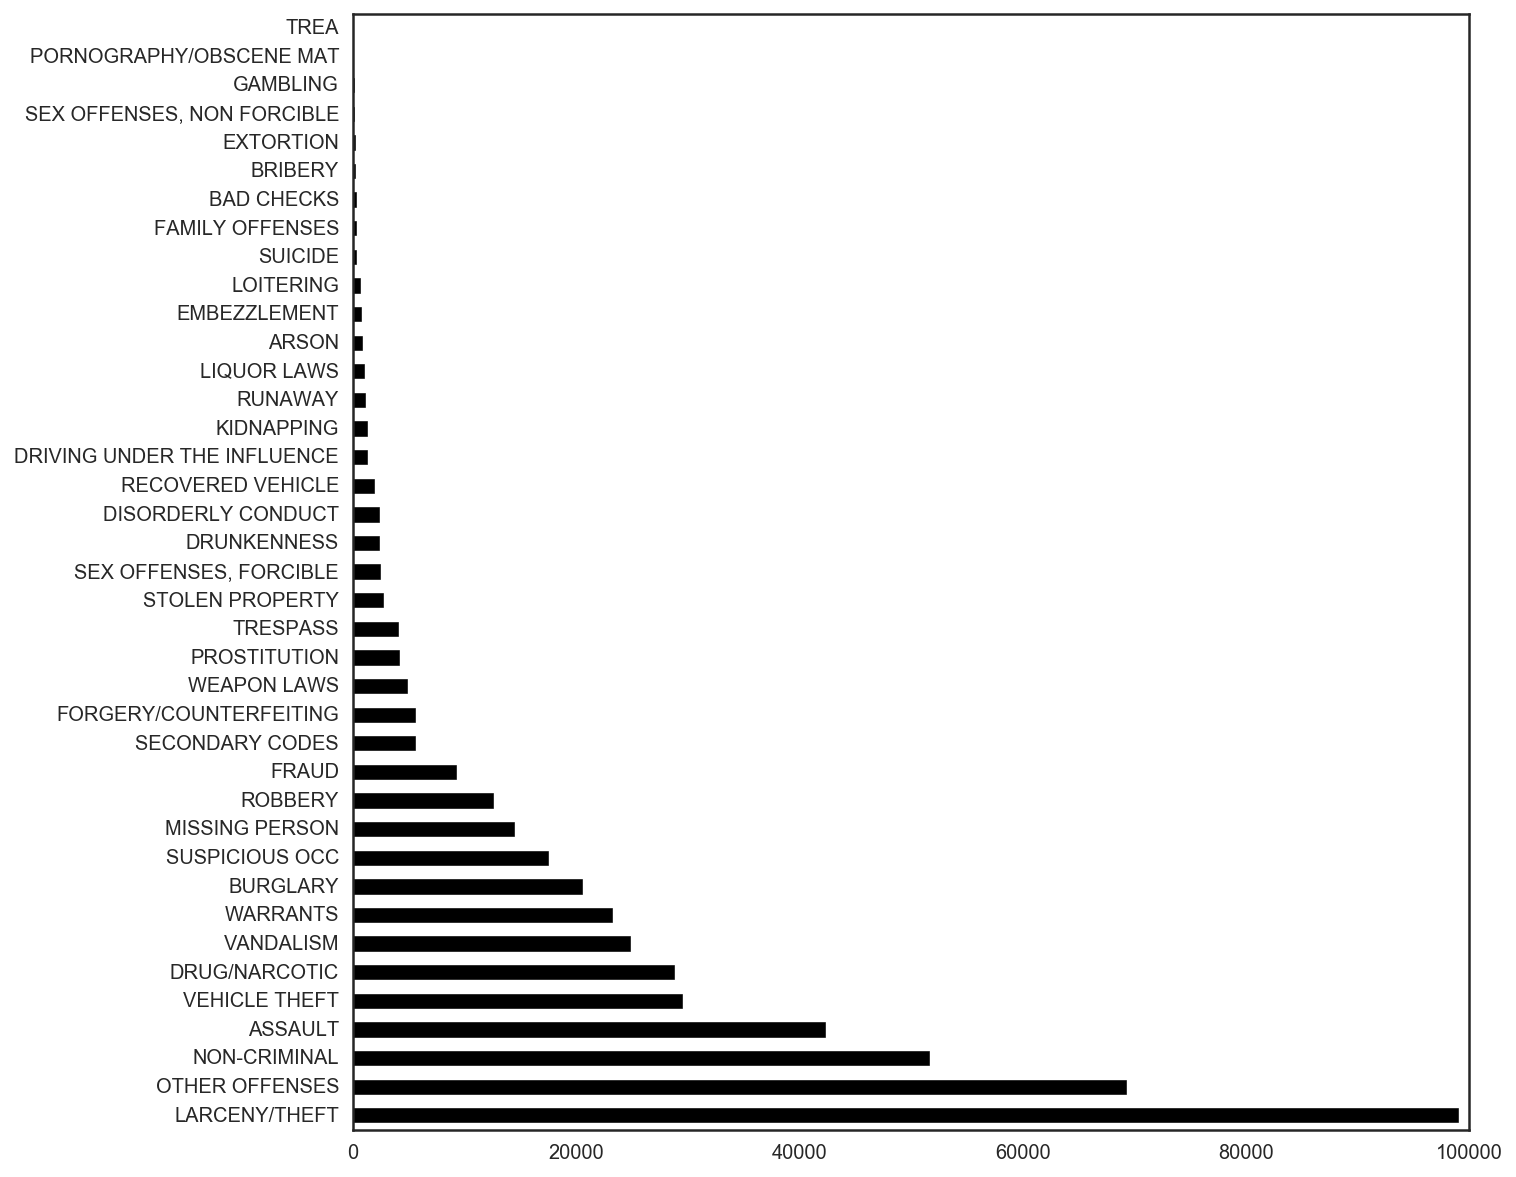

In [301]:
sns.set(rc={"figure.figsize": (10, 10)})
sns.set_style('white')


print crime_sub.Category.value_counts()[0:10]
crime_sub.Category.value_counts().plot(kind = 'barh', color = 'blue')

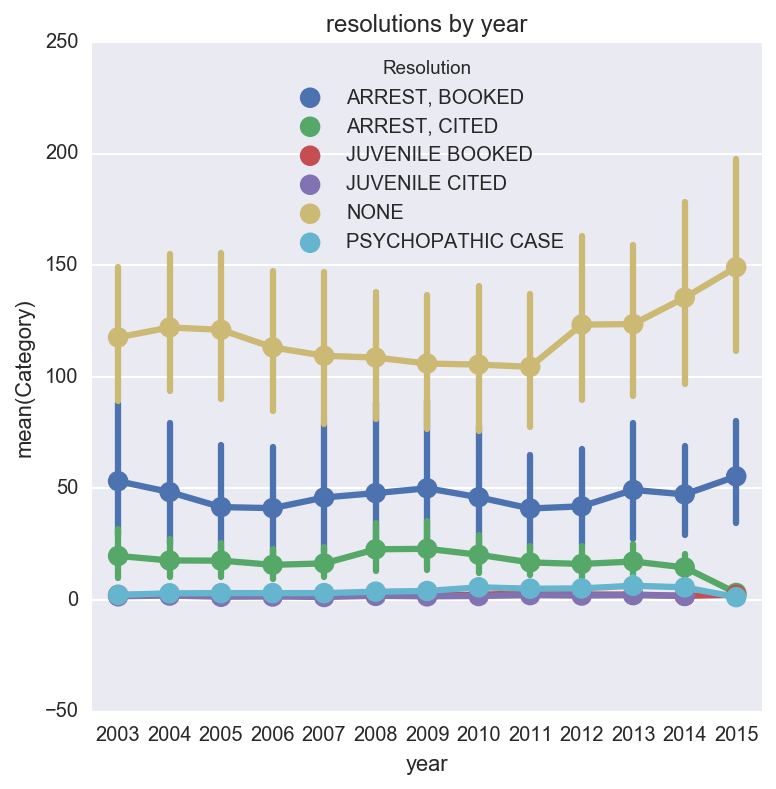

In [151]:

crime_eda = pd.DataFrame(crime_sub.groupby(['year','Resolution','match_district']).count().Category).reset_index()
crime_eda = crime_eda[crime_eda.Resolution.isin(['ARREST, BOOKED','ARREST, CITED','PSYCHOPATHIC CASE','JUVENILE BOOKED','JUVENILE CITED','NONE'])]

g = sns.pointplot(x = 'year',y= 'Category',data = crime_eda,hue = 'Resolution')
g.axes.set_title('resolutions by year')

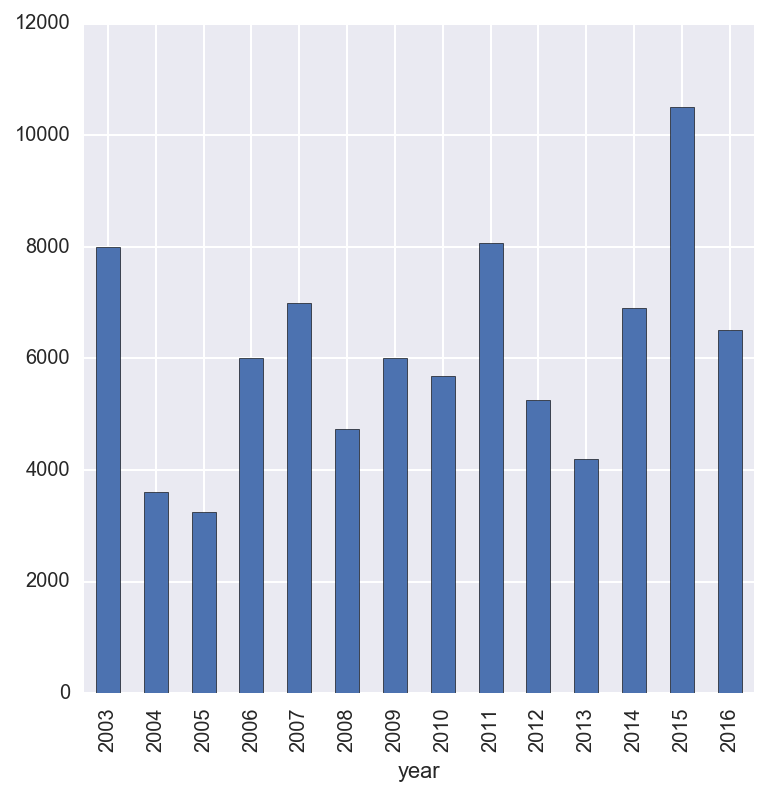

In [152]:
posts[posts.bed == 5].groupby('year').median().price.plot(kind = 'bar')

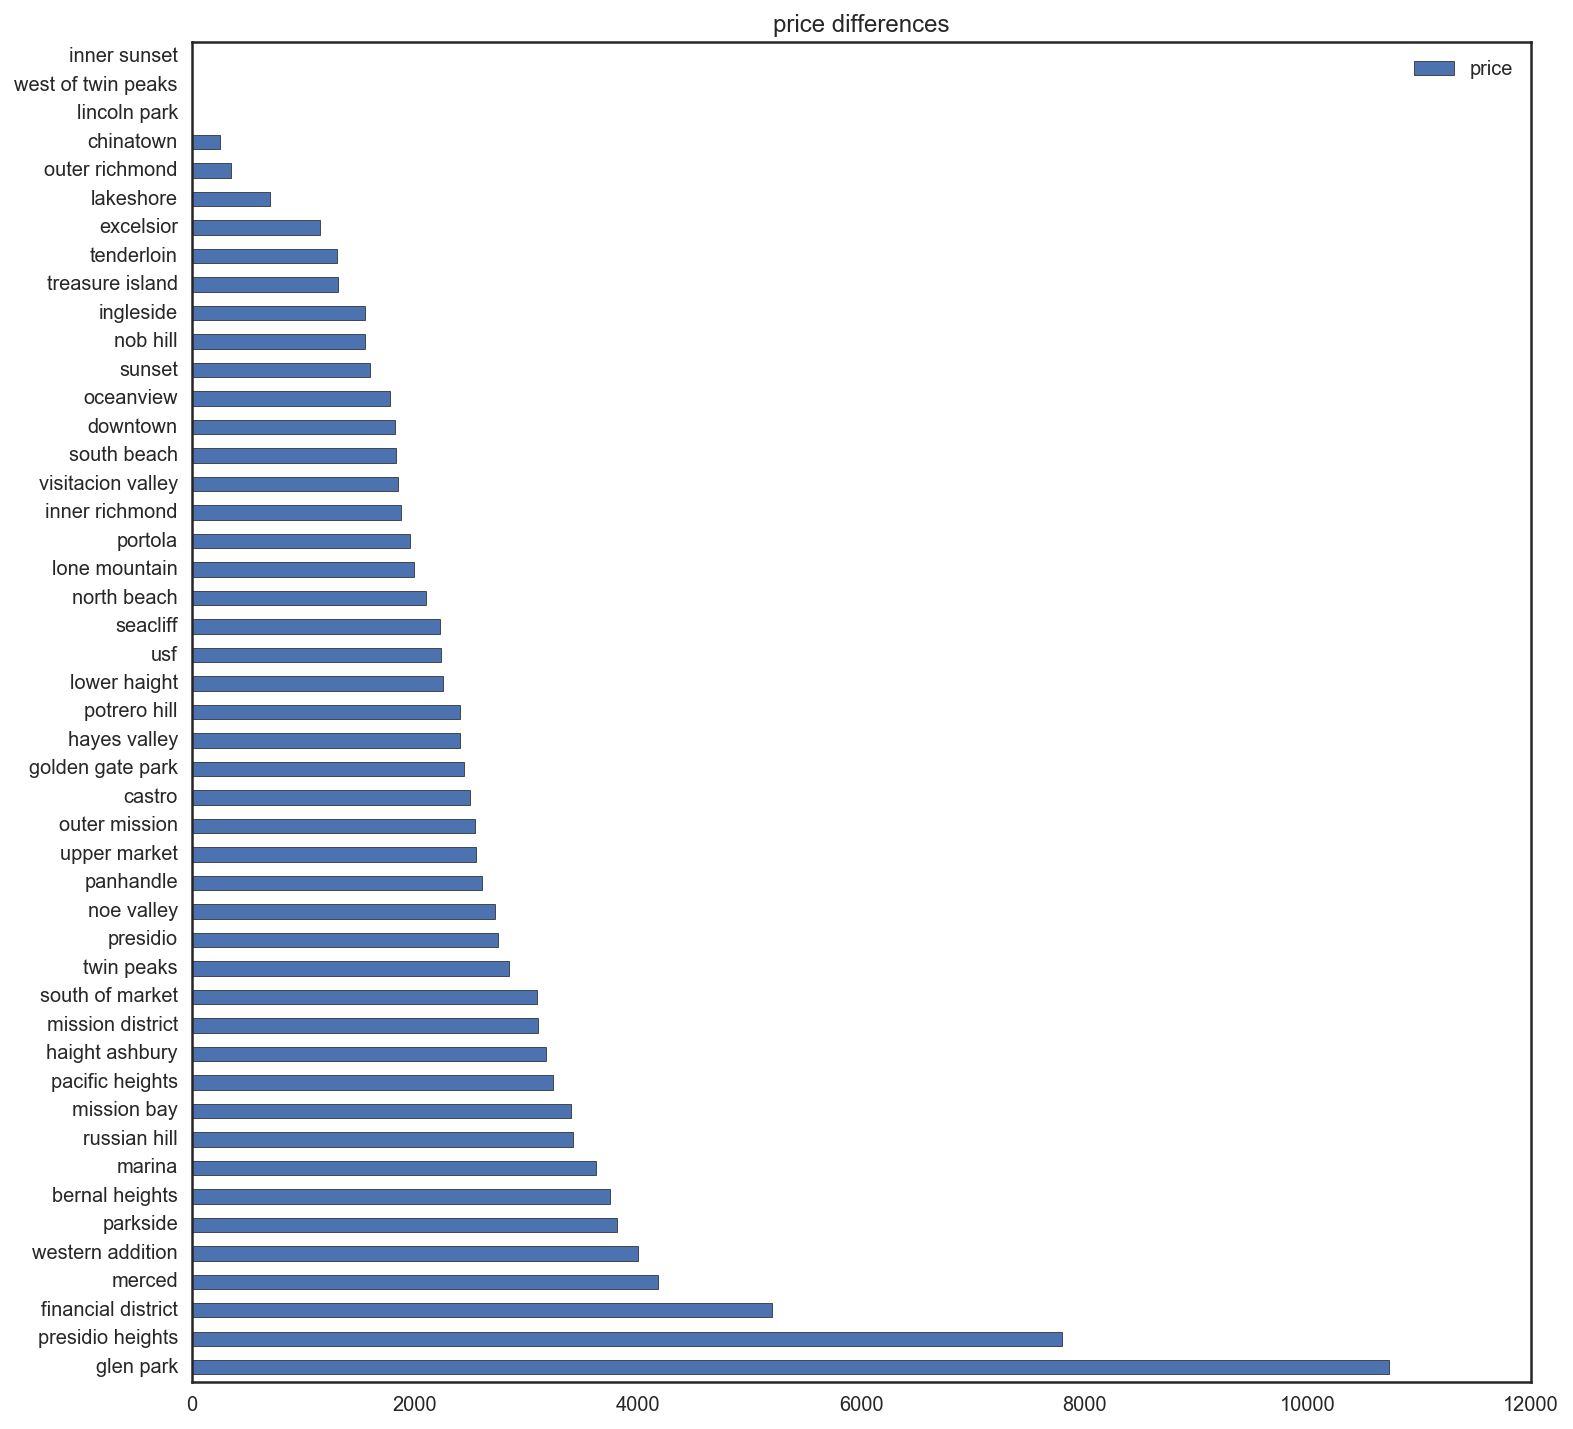

In [305]:
range_diffs = posts.groupby(['year','district1'])['price'].median().reset_index()
range_list = []
for i in range_diffs.district1.unique():
    a = range_diffs[range_diffs['district1'] == i]
    range_list.append(a.price.max()-a.price.min())
    

range_df = pd.DataFrame(range_list,range_diffs.district1.unique())
range_df.rename(columns = {0:'price'}, inplace = True)

sns.set(rc={"figure.figsize": (12, 12)})


sns.set_style('white')
range_df.sort_values('price', ascending = False).plot(kind = 'barh', title = 'price differences')

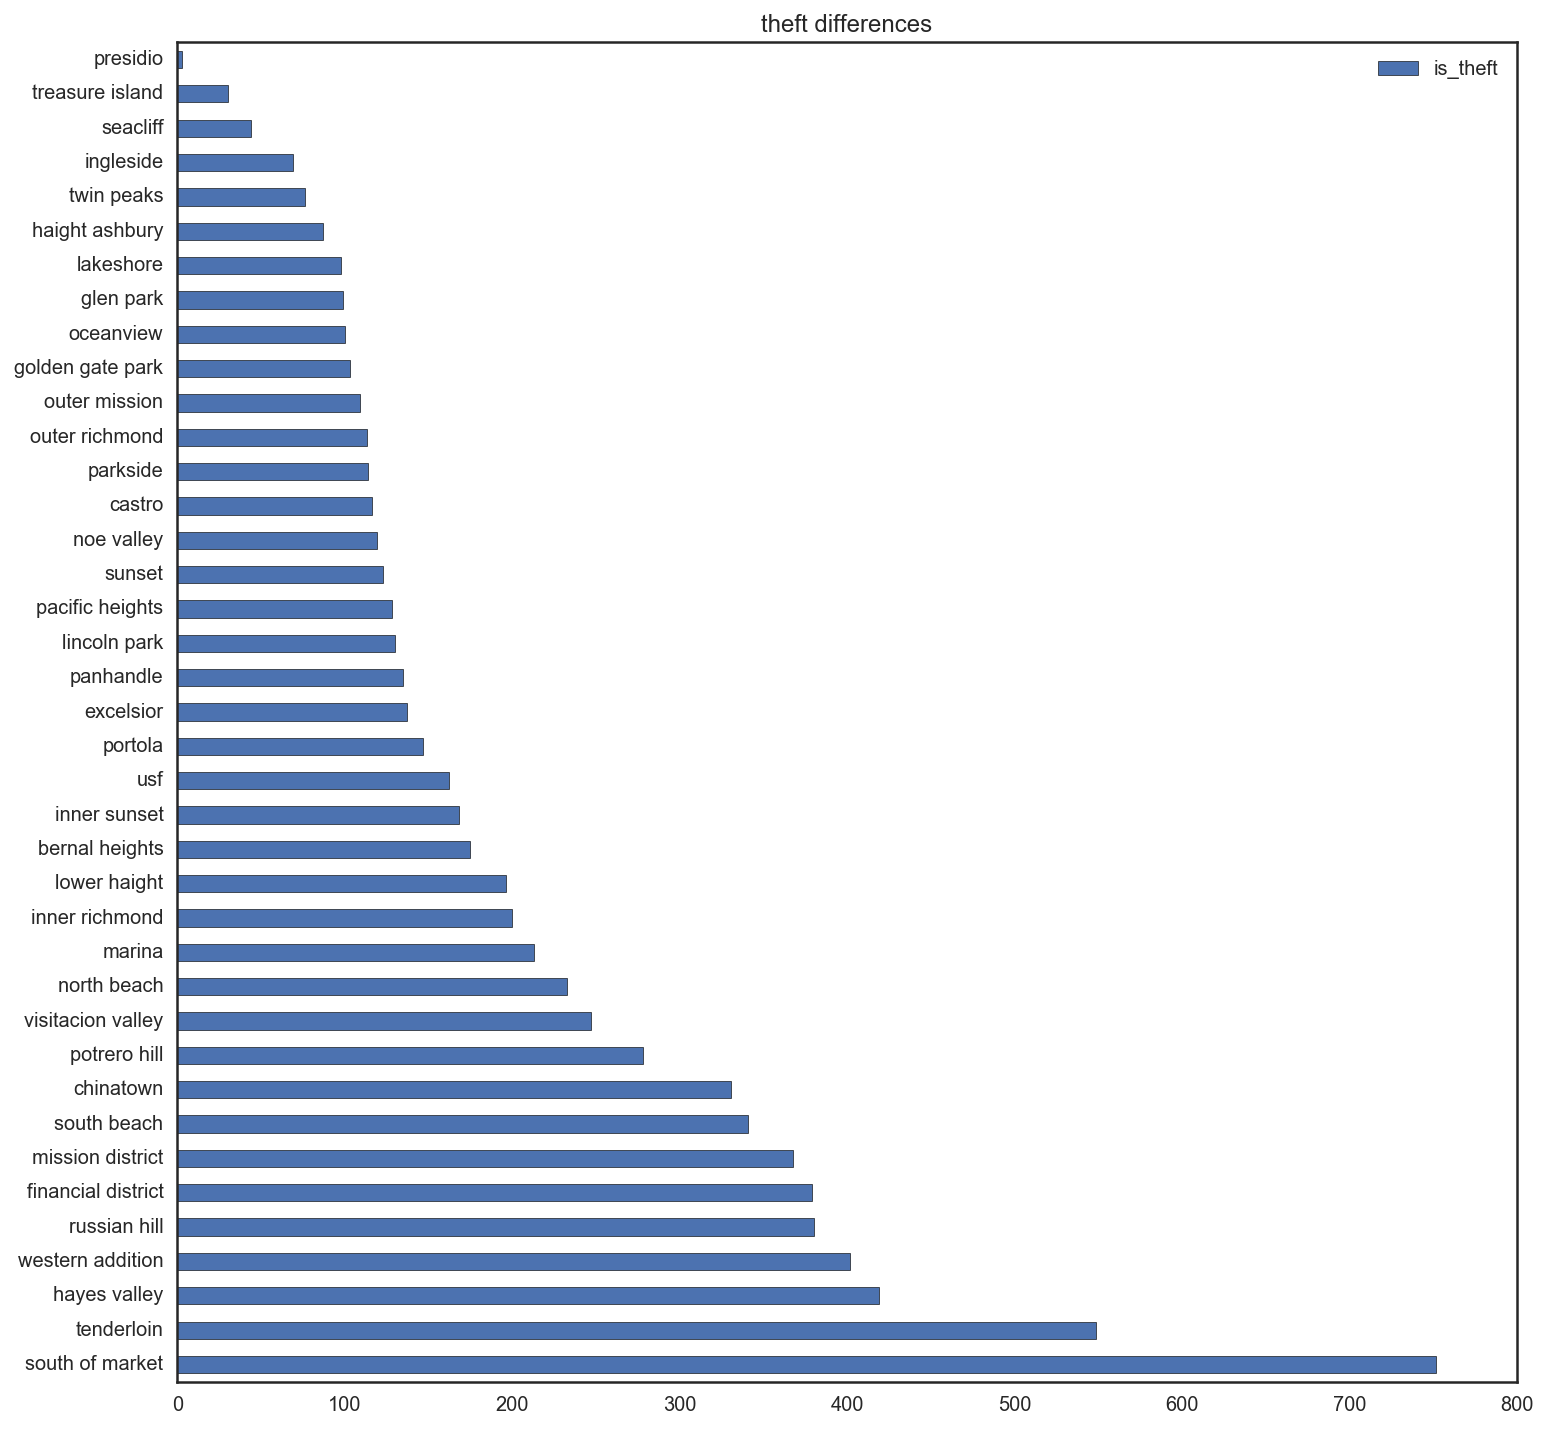

In [306]:
range_diffs = crime_eda.groupby(['year','match_district'])['is_theft'].sum().reset_index()
range_list = []
for i in range_diffs.match_district.unique():
    a = range_diffs[range_diffs['match_district'] == i]
    range_list.append(a.is_theft.max()-a.is_theft.min())

range_df = pd.DataFrame(range_list,range_diffs.match_district.unique())
range_df.rename(columns = {0:'is_theft'}, inplace = True)


sns.set(rc={"figure.figsize": (12, 12)})
sns.set_style('white')
range_df.sort_values('is_theft', ascending = False).plot(kind = 'barh', title = 'theft differences')

In [225]:
crime_sub[crime_sub.match_district == 'south of market'].Category.value_counts()

#['match_district']

LARCENY/THEFT                  2859
NON-CRIMINAL                   1397
OTHER OFFENSES                 1284
ASSAULT                         816
WARRANTS                        681
DRUG/NARCOTIC                   549
VANDALISM                       362
SUSPICIOUS OCC                  335
FRAUD                           266
MISSING PERSON                  257
ROBBERY                         255
BURGLARY                        241
VEHICLE THEFT                   240
FORGERY/COUNTERFEITING          147
TRESPASS                        121
WEAPON LAWS                      86
SECONDARY CODES                  73
SEX OFFENSES, FORCIBLE           71
DRUNKENNESS                      57
STOLEN PROPERTY                  49
DISORDERLY CONDUCT               34
LIQUOR LAWS                      26
KIDNAPPING                       25
RECOVERED VEHICLE                24
LOITERING                        14
EMBEZZLEMENT                     14
DRIVING UNDER THE INFLUENCE      13
PROSTITUTION                

In [226]:
crime_sub[crime_sub.match_district == 'mission district'].Category.value_counts()


OTHER OFFENSES                 1404
LARCENY/THEFT                   993
NON-CRIMINAL                    724
ASSAULT                         684
DRUG/NARCOTIC                   663
WARRANTS                        429
VEHICLE THEFT                   412
PROSTITUTION                    353
VANDALISM                       294
ROBBERY                         233
SUSPICIOUS OCC                  200
BURGLARY                        189
MISSING PERSON                  133
DISORDERLY CONDUCT              107
WEAPON LAWS                     104
FRAUD                           102
SECONDARY CODES                  89
FORGERY/COUNTERFEITING           67
DRUNKENNESS                      57
TRESPASS                         40
STOLEN PROPERTY                  40
LIQUOR LAWS                      36
SEX OFFENSES, FORCIBLE           34
RECOVERED VEHICLE                30
DRIVING UNDER THE INFLUENCE      24
KIDNAPPING                       19
LOITERING                        16
ARSON                       

In [227]:
crime_sub[crime_sub.match_district == 'tenderloin'].Category.value_counts()


DRUG/NARCOTIC                  2422
OTHER OFFENSES                 2265
LARCENY/THEFT                  1848
ASSAULT                        1460
NON-CRIMINAL                   1451
WARRANTS                       1118
SUSPICIOUS OCC                  505
ROBBERY                         397
VANDALISM                       395
VEHICLE THEFT                   334
BURGLARY                        314
PROSTITUTION                    265
MISSING PERSON                  235
FRAUD                           167
TRESPASS                        156
WEAPON LAWS                     145
FORGERY/COUNTERFEITING          143
SECONDARY CODES                 138
DISORDERLY CONDUCT              123
STOLEN PROPERTY                  95
DRUNKENNESS                      71
SEX OFFENSES, FORCIBLE           56
KIDNAPPING                       46
LIQUOR LAWS                      40
LOITERING                        33
RECOVERED VEHICLE                28
DRIVING UNDER THE INFLUENCE      16
ARSON                       